In [1]:
%matplotlib widget
import matplotlib.pyplot as plt

from mavisetc.instruments import (MAVIS_IFS, MAVIS_Imager)
from mavisetc.sources import (flat_source, template_source, stellar_source)
from mavisetc.background import sky_source

import numpy as np
import matplotlib
from matplotlib.ticker import MultipleLocator

params = {'axes.labelsize': 16,
        'font.size': 14.0,
        'axes.linewidth': 1.20,
        'lines.linewidth': 1.0,
        'xtick.labelsize': 14.0,
        'ytick.labelsize': 14.0,
        'font.family': 'Serif',
        'font.weight': 'roman',
        'font.serif': ['Times'],
        'text.usetex': True}
plt.rcParams.update(params)

# Load in some sky and source models

In [2]:
###### SKY MODEL ########
#initialize the sky model, working in offline mode 
#this will just use the nearest pre-determined sky in FLI
skyModel = sky_source(offline=True)

#set sky to dark, zenith, and standard PWV
skyModel.set_params(fli=0.0, airmass=1.16, pwv=10)

##### SOURCE MODELS ######
#we'll just initialize a flat model, (galaxy) template model, and stellar model for now.
flatSource = flat_source()
templateSource = template_source()
stellarSource = stellar_source()

## Spectrograph
#### 1) Let's look at sensitivity limits for the coarse pixel scale

1 hour on source (4 x 900s integrations), 50mas pixel scale, 3x3 spatial binning

In [ ]:
ndit = 4 # number of exposures
dit = 900 # integration time per exposure

colors = ['C0', 'C3', 'skyblue', 'indianred']
labels = ['LR-blue', 'LR-red', 'HR-blue','HR-red']
names = ['LRB', 'LRR', 'HRB', 'HRR']

#coarse spaxel scale
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
for ii, grating in enumerate(labels):
    #initialze the MAVIS IFS with this grating mode and pixel scale
    mavis_ifs = MAVIS_IFS(mode=grating, pix_scale=0.025, throughput_model='new')
    
    #estimate the limiting magnitude for a 10 sigma point source detection, 3x3 spatial binning
    limiting_mag = mavis_ifs.get_mag_limit(sn=10, sky=skyModel, dit=dit, ndit=ndit, binning=3, norm='point')
    
    #limiting_mag[(mavis_ifs.inst_wavelength < 0.37) | (mavis_ifs.inst_wavelength > 0.95)] = np.nan
    ax.plot(mavis_ifs.inst_wavelength*1e3, limiting_mag, linewidth=1.5, color=colors[ii])
        
#add some axis labels
plt.ylabel(r'10$\sigma$ limiting mag in 1 hr [AB mag]')

plt.xlabel('Wavelength [nm]')

#set some sensible axis limits
plt.xlim(370, 950)
plt.ylim(16, 21)


ax.grid(True, color='black', zorder=4, alpha=0.3)
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(20))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

plt.show()


#### 2) Comparison of the surface brightness sensitivity for fine and coarse spaxel scales with the low-res red grating.

1 hour on source (4 x 900s integrations), per spatial pixel

In [ ]:
ndit = 4 # number of exposures
dit = 900 # integration time per exposure

fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)

for pixel_scale in [0.025,0.05]:
    mavis_ifs = MAVIS_IFS(mode='LR-red', pix_scale=pixel_scale)

    #estimate the limiting SB for a 10 sigma detection per pixel
    limiting_mag = mavis_ifs.get_mag_limit(sn=10, sky=skyModel, dit=dit, ndit=ndit, binning=1, norm='extended')
        
    #plot it!
    ax.plot(mavis_ifs.inst_wavelength, limiting_mag, linewidth=1)

#set some sensible axis limits
plt.xlim(0.5, 1.05)
plt.ylim(10, 16)
ax.grid(True, color='black', zorder=4, alpha=0.3)

#add some axis labels
plt.ylabel('limiting SB [AB mag/arcsec$^2$]')
plt.xlabel('wavelength [microns]')
plt.show()


#### 3) Simulated observation of star-forming galaxy at z=0.4, with an i-band surface brightness of 19.
    
low-resolution red grating, 50mas pixel scale, 4 hours on source (12 x 1200s integrations)

In [ ]:
#set up the template
templateSource.set_params(template='Sc', redshift=0.4, obs_mag=19, obs_band='sdss_i', norm='extended')

#set up the IFS
mavis_ifs = MAVIS_IFS(mode='LR-red', pix_scale=0.05)

#generate a mock observations
noisy_template, noiseless_template = mavis_ifs.observe(templateSource, sky=skyModel, dit=1200, ndit=12)

#plot it!
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
ax.plot(mavis_ifs.inst_wavelength, noisy_template/1e-16, color='black')
ax.plot(mavis_ifs.inst_wavelength, noiseless_template/1e-16, color='C3')

#some sensibile axis limits
plt.xlim(mavis_ifs.inst_wavelength.min(), mavis_ifs.inst_wavelength.max())
plt.ylim(-1, 7) #10^-16 erg/s/cm^2/A

#labels
plt.xlabel('Wavelength [microns]')
plt.ylabel('Flux [$10^{-16}$ erg/s/cm$^{2}$/$\mathrm{\AA}$]')
plt.show()

#### 4) Exposure time estimates for a compact (point source) ETG at z=0.8

In [ ]:
#set up the template
templateSource.set_params(template='E', redshift=0.8, obs_mag=25, obs_band='sdss_i', norm='point')

#set up the IFS
mavis_ifs = MAVIS_IFS(mode='LR-red', pix_scale=0.05)

#number of 1200s exposures to reach S/N of at least 5 near redshifted Hbeta
_,_ = mavis_ifs.calc_sn(templateSource, sky=skyModel, dit=1200., sn=5, ref_wl=4855.5*1.8/1e4)

#S/N near Hbeta given 10 x 600s exposures
_,_ = mavis_ifs.calc_sn(templateSource, sky=skyModel, dit=600., ndit=10, ref_wl=4855.5*1.8/1e4)

#### 5) Exploring parameters of the bundled the stellar library

(9501, 7, 7, 6)
Available metallicities ([Fe/H]):  -2.5 -2.0 -1.5 -1.0 -0.5 0.0 0.5
Available T_eff (K):  3000.0 4000.0 5000.0 6000.0 7000.0 8000.0
Available log(g):  -0.5 0.5 1.5 2.5 3.5 4.5 5.5


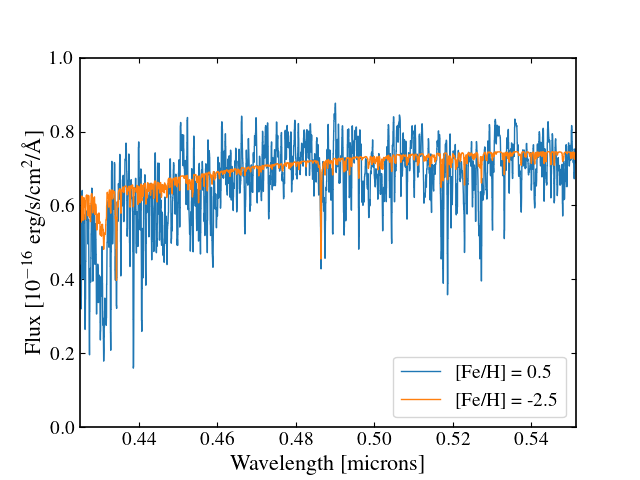

In [5]:
mavis_ifs = MAVIS_IFS(mode='HR-blue', pix_scale=0.025)
print(stellarSource.templates.shape)
#Print out the available grid of stellar parameters
print("Available metallicities ([Fe/H]): ", *stellarSource.all_metallicity)
print("Available T_eff (K): ", *stellarSource.all_teff)
print("Available log(g): ", *stellarSource.all_logg)

#let's look at some spectra as a function of metallicity
fig, ax = plt.subplots()

for metallicity in [0.5,-2.5]:
    stellarSource.set_params(metallicity=metallicity, logg=1.5, teff=5000, obs_mag=19, obs_band='sdss_r')

    #generate spectra
    _, noiseless_template = mavis_ifs.observe(stellarSource, sky=skyModel, dit=1200, ndit=3)

    ax.plot(mavis_ifs.inst_wavelength, noiseless_template/1e-16, label='[Fe/H] = {0}'.format(str(metallicity)))

ax.legend()

#some sensibile axis limits
plt.xlim(mavis_ifs.inst_wavelength.min(), mavis_ifs.inst_wavelength.max())
plt.ylim(0, 1) #10^-16 erg/s/cm^2/A

#labels
plt.xlabel('Wavelength [microns]')
plt.ylabel('Flux [$10^{-16}$ erg/s/cm$^{2}$/$\mathrm{\AA}$]')
plt.show()

## Imager

#### 1) Limiting magnitudes for standard broadband filters

In [ ]:
#initialize the imager
mavis_imager = MAVIS_Imager()

#SDSS broadband filters
bands = ['asahi_u', 'asahi_g', 'asahi_r', 'asahi_i', 'asahi_z']

cmap = matplotlib.cm.get_cmap('magma')
colors = cmap(np.linspace(0.1,0.8,4))[::-1]

#assume 4 x 900s exposures, 3x3 binning
pivots, limits = mavis_imager.get_mag_limit(sn=5, sky=skyModel, dit=900, ndit=4, 
                                            band=bands, norm='point', binning=3)
pivots = np.array(pivots)*1e3

#plot it!
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
ax.plot(pivots, limits, 's', mec='black', mew=2, ms=8)

#some sensibile axis limits
dpivot = pivots.ptp()
plt.xlim(min(pivots)-0.05*dpivot, max(pivots)+0.05*dpivot)
plt.ylim(26, 30) 

ax.grid(True, color='black', zorder=4, alpha=0.3)

#labels
plt.xlabel('Filter wavelength [nm]')
plt.ylabel(r'5$\sigma$ Limiting AB magnitude [4$\times$900s]')
plt.show()

#### 2) What about swapping out detectors?

In [ ]:
#initialize the imager
mavis_imager = MAVIS_Imager()

#swap out for the CCD290
from mavisetc.detectors import CCD250
mavis_imager_250 = MAVIS_Imager(detector=CCD250) 

#SDSS broadband filters
bands = ['asahi_u', 'asahi_g', 'asahi_r', 'asahi_i', 'asahi_z']

#Baseline setup with CCD250. 3 x 1200s exposures, 3x3 binning
pivots, limits = mavis_imager.get_mag_limit(sn=10, sky=skyModel, dit=900, ndit=4, 
                                            band=bands, norm='point', binning=3)

#compare with the CCD290. Assume lower CR rate and longer exposure
pivots_250, limits_250 = mavis_imager_250.get_mag_limit(sn=10, sky=skyModel, dit=1200, ndit=3, 
                                                           band=bands, norm='point', binning=3)

#plot it!
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
ax.plot(pivots, limits, 's', mec='black', mew=2, ms=8, label='baseline')
ax.plot(pivots_250, limits_250, '^', mfc='white', mec='C3', mew=2, ms=8, label='CCD250')

#some sensibile axis limits
plt.xlim(0.9*min(pivots), 1.1*max(pivots))
plt.ylim(25.5, 29.5) 

ax.grid(True, color='black', zorder=4, alpha=0.3)
ax.legend()

#labels
plt.xlabel('Pivot wavelength [microns]')
plt.ylabel('Limiting AB magnitude')
plt.show()

#### 3) Imaging exposure times for a compact (point source) ETG at z=0.8

In [ ]:
#set up the template
templateSource.set_params(template='E', redshift=0.8, obs_mag=28, obs_band='sdss_i', norm='point')

#initialize the imager
mavis_imager = MAVIS_Imager()

#number of 600s exposures to reach S/N of at least 10 
mavis_imager.calc_sn(templateSource, sky=skyModel, dit=600., band=['sdss_g','sdss_r','sdss_i','sdss_z'], sn=10)

#S/N given 10 x 300s exposures
mavis_imager.calc_sn(templateSource, sky=skyModel, dit=300., ndit=10, band=['sdss_g','sdss_r','sdss_i','sdss_z'])